- Likelihood
- Prior
- Posterior

In [1]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform, get_fd_waveform

%matplotlib inline

import numpy as np
import scipy as sp

from matplotlib import pyplot as plt

 ## Generating Waveform Template With Parameters $\vec{\theta}$
 
 Defining vector containing parameters $\vec{\theta}$ to be: 
 $$\vec{\theta} = (\,m_1,\, m_2,\,\vec{s}_1,\,\vec{s}_2,\, e,\, d_l,\,)$$


In [2]:
# Generates template in frequency domain. Returns h+ and hx frequency series. 

def GenerateWaveformTemplateFD(theta, approximant, delta_t, delta_f, f_lower, f_upper):

    m1, m2, s1, s2, ecc, distance = theta

    hp, hc = get_fd_waveform(approximant=approximant,
                         mass1=m1,
                         mass2=m2,
                         delta_t=delta_t,
                         eccentricity=ecc,
                         delta_f=delta_f,
                         f_lower=f_lower, 
                         f_upper=f_upper)
    
    return hp, hc

## Noise Weighted Inner Product
The noise weighted inner product of two vectors $\langle \,a\,|\,b\,\rangle$ is equal to: 

$$
\langle \,a\,|\,b\,\rangle = 4 \Re \int_{0}^{\infty} \frac{\tilde{a}(f)\,\tilde{b^*}(f)}{S_n(f)} df
$$

This is used to calculate Likelihood

In [3]:
# Function to calculate the noise weighted inner product of two vectors
# a and b (FFTs) with noise vector Sn (PSD); df = freq. bin size
# Note: a, b, and Sn must be same length

def InnerProduct(a, b, Sn, df):
    
    b_conj = np.conj(b)
    
    integrand = []
    
    for i in range(0,len(a)):
        intgrnd = a[i]*b_conj[i]/Sn[i]
        integrand.append(intgrnd)
            
    result_complex = 4*np.sum(integrand)*df
    
    result = np.real(result_complex)
    
    return result

## Likelihood

Likelihood of observing data $ d = \{d_1, d_2, \ldots, d_{\mathrm{N}_f}\} $ with a set of parameters described by $\vec{\theta}$ is equal to:

$$
p(d\,|\,\vec{\theta}) = \exp \left(-\frac{1}{2}\langle h(\vec{\theta})-d\,|\,h(\vec{\theta})-d\rangle\right),
$$

In [4]:
# Function to calculate the likelihood of data given parameters theta that
# generate strain h_theta (frequency series) with noise Sn (PSD); df = freq. bin size
# Note: h_theta, data, and Sn must all be same length

def LogLikelihood(data, h_theta, Sn, df):
    
    h_minus_d = h_theta - data
    
    result = (-1.0/2)*InnerProduct(h_minus_d, h_minus_d, Sn, df) 
    
    return result

## Prior 

The prior is the knowledge of the distribution of model parameters that we have *before* taking any measuments. 

In [1]:
# Function to calculate the prior for a set of parameters theta = (m1, m2, s1, s2, ecc, distance)

def LogPrior(theta):
    
    logprior = 0
    
    m1, m2, s1, s2, ecc, distance = theta
    
    # [insert stuff here]
    
    return logprior

## Posterior

Posterior = product of likelihood and prior

$$
p(\vec{\theta}\,|\,d ) = \frac{p(\vec{\theta})\,p(d\,|\,\vec{\theta})}{p(d)},
$$

In [6]:
def LogPosterior(data, h_theta, theta, Sn, df): 
    
    loglikelihood = LogLikelihood(data, h_theta, Sn, df)
    
    logprior = LogPrior(theta)
    
    logposterior = loglikelihood+logprior
    
    return logposterior

Let's try it out with two different sets of parameters that are exactly the same but have different values of eccentricity.

Reminder:  $\vec{\theta} = (\,m1,\, m2,\,\vec{s}_1,\,\vec{s}_2,\, e,\, d_l,\,)$

In [7]:
# Defining parameters in theta

e1 = 0.0000001
e2 = 0.0001

m1 = 10 # solar masses
m2 = 10 # solar masses
s1 = 0
s2 = 0
distance = 100 # mega-parsecs


# Theta (only diff is eccentricity)
# Let theta1 be parameters for our "template" and theta2 be parameters for our "data"

theta1 = m1, m2, s1, s2, e1, distance
theta2 = m1, m2, s1, s2, e2, distance


# Other important values

approximant = 'EccentricFD'
f_lower = 20.          # Hz
f_upper = 300.         # Hz
delta_t = 1.0/8192     # s
delta_f = 0.001        # Hz

In [8]:
# Generating Waveforms

hp1, hc1 = GenerateWaveformTemplateFD(theta1, approximant, delta_t, delta_f, f_lower, f_upper)
hp2, hc2 = GenerateWaveformTemplateFD(theta2, approximant, delta_t, delta_f, f_lower, f_upper)

In [9]:
plt.semilogx(hp1.sample_frequencies, hp1, label='$h_+$ strain')
plt.semilogx(hp1.sample_frequencies, hc1, label='$h_x$ strain')
plt.xlabel("Log Frequency (Hz)")
plt.ylabel("GW Strain")
plt.xlim(15,300)
plt.legend()

/home/pycbc/pycbc-software/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [10]:
# Generating Noise Curve 

merger = Merger("GW150914")
strain = merger.strain('H1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048).crop(2, 2)

# Making PSD 
psd = strain.psd(4)
psd = interpolate(psd, delta_f)
psd = inverse_spectrum_truncation(psd, 4 * strain.sample_rate)

noise = psd[:len(hp1)]

fs = noise.delta_f * np.arange(noise.data.size)

In [11]:
# Checking lengths
print len(noise)
print len(hp1)
print len(hp2)

219859
219859
219859


Text(0.5,1,u'Noise Curve')

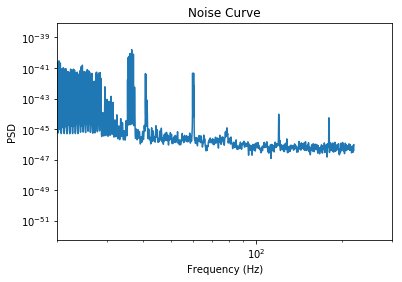

In [12]:
# Plotting noise curve
plt.loglog(fs, noise)
plt.xlim(f_lower, f_upper)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Noise Curve")

In [13]:
# -- Calculating likelihoods --

# Remember: theta1 has parameters for our "template" and theta2 has parameters for our "data"
# aka hp2 and hc2 = "data" and hp1 and hc1 = "template"

loglikelihood_plus = LogLikelihood(hp2, hp1, noise, delta_f)
loglikelihood_cross = LogLikelihood(hc2, hc1, noise, delta_f)

print "h+ log likelihood:", loglikelihood_plus
print "hx log likelihood:", loglikelihood_cross

h+ log likelihood: -0.266133018054
hx log likelihood: -0.266133018044


In [14]:
# -- Calculating prior --

logprior = LogPrior(theta1)

print "log prior:", logprior

0.0
9.21034037198
-inf
log prior: -inf


/home/pycbc/pycbc-software/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
